In [ ]:
# imports
import os
import glob
import numpy as np
import pandas as pd

from scipy.fft import fft

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

import matplotlib.pyplot as plt
import seaborn as sns

from xgboost import XGBClassifier

In [ ]:
# pre processing with 20 freqs
def extract_features(signal: np.ndarray, n_freqs=20) -> dict:
    signal = signal.astype(float)
    fft_vals = np.abs(fft(signal))

    features = {}
    for x in range(1, n_freqs + 1):
        features[f"fft_{x}"] = float(fft_vals[x])

    return features

'''Why this type of pre processing?

Here we can capture the pattern while escaping from overffiting the model.
One more great point is that it keeps the model relative "light"
'''

In [ ]:
# loading data
def load_dataset(base_path: str):
    X = []
    y = []

    # normal
    normal_path = os.path.join(base_path, "normal")
    normal_files = glob.glob(os.path.join(normal_path, "*.csv"))

    for file in normal_files:
        df = pd.read_csv(file, header=None)
        signal = df.iloc[:, 0].values
        features = extract_features(signal)
        X.append(features)
        y.append("normal")

    # imbalance
    imbalance_path = os.path.join(base_path, "imbalance")
    imbalance_folders = os.listdir(imbalance_path)

    for folder in imbalance_folders:
        folder_path = os.path.join(imbalance_path, folder)
        files = glob.glob(os.path.join(folder_path, "*.csv"))

        for file in files:
            df = pd.read_csv(file, header=None)
            signal = df.iloc[:, 0].values
            features = extract_features(signal)
            X.append(features)
            y.append("imbalance")
    
    return pd.DataFrame(X), pd.Series(y)

'''In this section:

- Structuring and Labeling
- Eliminate the use of a index archive on the source of the project, once this block
is using the own directory hierachy

'''

In [52]:
# source
BASE_PATH = "/Users/pedrocm/Downloads/archive"

X_fft, y_fft = load_dataset(BASE_PATH)

print(X_fft.shape)
print(y_fft.value_counts())

(382, 20)
imbalance    333
normal        49
Name: count, dtype: int64


In [ ]:
# had to use LE here because of this ValueError from XGB
"ValueError: Invalid classes inferred from unique values of y. "
"Expected: [0 1], got ['imbalance' 'normal']"

from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()

y_encoded = le.fit_transform(y_fft)

In [54]:
# spliting test and train
X_train, X_test, y_train, y_test = train_test_split(
    X_fft, 
    y_encoded,
    test_size=0.3,
    random_state=42,
    stratify=y_encoded
)

In [ ]:
# model training
xgb = XGBClassifier(
    n_estimators=300,
    max_depth=5,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    eval_metric="logloss",
    random_state = 42
)

xgb.fit(X_train, y_train)


'''Why XGB?

'''

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=300, n_jobs=None,
              num_parallel_tree=None, ...)

In [56]:
# eval
y_pred = xgb.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.87      0.97      0.92       100
           1       0.00      0.00      0.00        15

    accuracy                           0.84       115
   macro avg       0.43      0.48      0.46       115
weighted avg       0.75      0.84      0.80       115



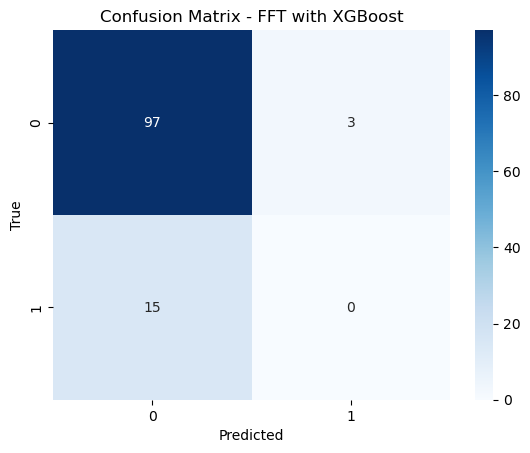

In [58]:
# confusion matrix
cm = confusion_matrix(y_test, y_pred)

sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=xgb.classes_,
    yticklabels=xgb.classes_
)

plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix - FFT with XGBoost")
plt.show()